<a href="https://colab.research.google.com/github/kridtapon/Monte-carlo-simulation-On-MA-Crossover-Strategy/blob/main/Monte_carlo_simulation_On_MA_Crossover_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.4/527.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully unins

[*********************100%***********************]  1 of 1 completed


Mean Profit: 241751.3611029362
Median Profit: 100432.58607059228
Standard Deviation of Profit: 321673.7054742444
Mean Max Drawdown: -0.5967532166266112
Median Max Drawdown: -0.6367040975475031
Standard Deviation of Max Drawdown: 0.1046136535088761


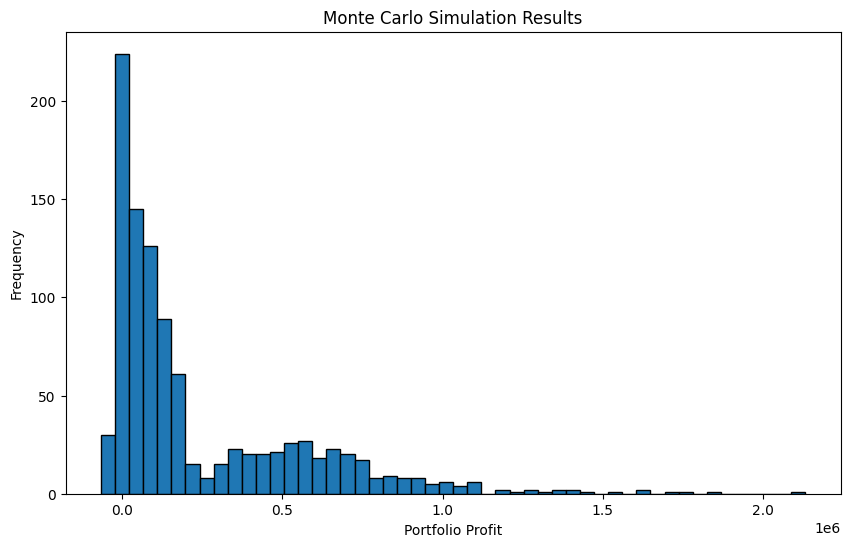

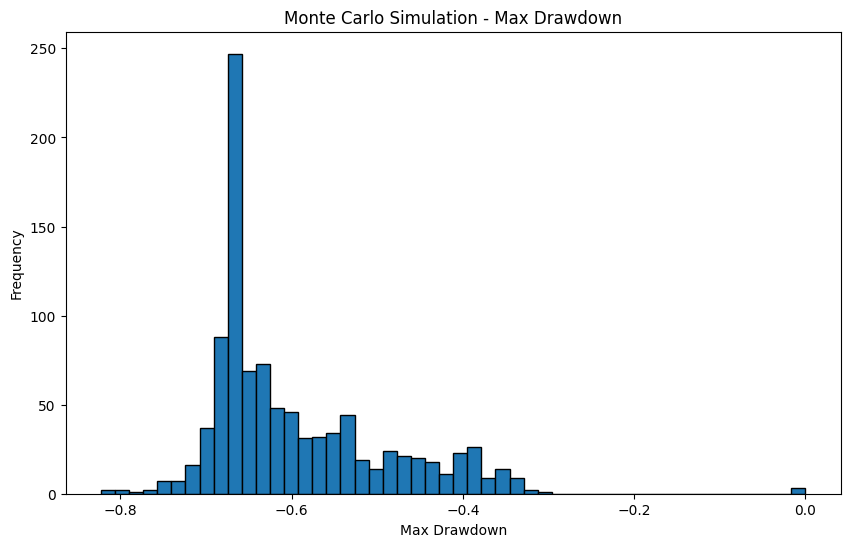

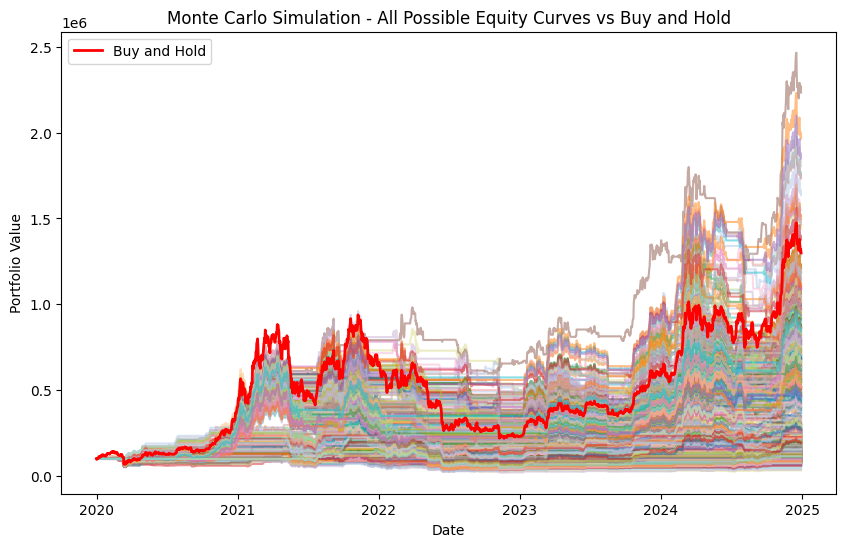

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate moving averages
def calculate_moving_averages(df, short_window, long_window):
    """Calculate short-term and long-term moving averages."""
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()
    return df

# Function to calculate Maximum Drawdown (MaxDD)
def calculate_max_drawdown(equity_curve):
    """Calculate the maximum drawdown of an equity curve."""
    drawdowns = equity_curve / equity_curve.cummax() - 1
    max_drawdown = drawdowns.min()
    return max_drawdown

# Define the stock symbol and time period
symbol = 'BTC-USD'
start_date = '2020-01-01'
end_date = '2024-12-31'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Monte Carlo parameters
num_simulations = 1000
initial_cash = 100_000
fees = 0.001
simulation_results = []
equity_curves = []  # List to store all equity curves
max_drawdowns = []  # List to store max drawdowns for each simulation

# Perform Monte Carlo simulations
for i in range(num_simulations):
    # Randomize moving average window lengths
    short_window = np.random.randint(1, 200)  # Random short window between 5 and 50
    long_window = np.random.randint(1, 200)  # Random long window between 20 and 200

    # Recalculate moving averages
    df = calculate_moving_averages(df, short_window, long_window)

    # Define entry and exit signals based on moving average crossover
    df['Entry'] = (
        (df['Short_MA'] > df['Long_MA']) &
        (df['Short_MA'].shift(1) <= df['Long_MA'].shift(1))
    )
    df['Exit'] = (
        (df['Short_MA'] < df['Long_MA']) &
        (df['Short_MA'].shift(1) >= df['Long_MA'].shift(1))
    )

    # Convert signals to boolean arrays
    entries = df['Entry'].to_numpy()
    exits = df['Exit'].to_numpy()

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=entries,
        exits=exits,
        init_cash=initial_cash,
        fees=fees
    )

    # Store the final portfolio value
    simulation_results.append(portfolio.total_profit())

    # Store the equity curve for this simulation
    equity_curves.append(portfolio.value())  # Use portfolio.value() to get the equity curve

    # Calculate the Max Drawdown for this simulation
    max_dd = calculate_max_drawdown(portfolio.value())
    max_drawdowns.append(max_dd)

# Analyze results
simulation_results = np.array(simulation_results)
mean_profit = np.mean(simulation_results)
median_profit = np.median(simulation_results)
std_dev_profit = np.std(simulation_results)
mean_max_drawdown = np.mean(max_drawdowns)
median_max_drawdown = np.median(max_drawdowns)
std_dev_max_drawdown = np.std(max_drawdowns)

print(f"Mean Profit: {mean_profit}")
print(f"Median Profit: {median_profit}")
print(f"Standard Deviation of Profit: {std_dev_profit}")
print(f"Mean Max Drawdown: {mean_max_drawdown}")
print(f"Median Max Drawdown: {median_max_drawdown}")
print(f"Standard Deviation of Max Drawdown: {std_dev_max_drawdown}")

# Calculate Buy-and-Hold strategy (no trades)
buy_and_hold_value = initial_cash * (df['Close'] / df['Close'].iloc[0])

# Plot histogram of simulation results
plt.figure(figsize=(10, 6))
plt.hist(simulation_results, bins=50, edgecolor='k')
plt.title('Monte Carlo Simulation Results')
plt.xlabel('Portfolio Profit')
plt.ylabel('Frequency')
plt.show()

# Plot histogram of Max Drawdowns
plt.figure(figsize=(10, 6))
plt.hist(max_drawdowns, bins=50, edgecolor='k')
plt.title('Monte Carlo Simulation - Max Drawdown')
plt.xlabel('Max Drawdown')
plt.ylabel('Frequency')
plt.show()

# Plot all equity curves with different colors and Buy-and-Hold comparison
plt.figure(figsize=(10, 6))
# Generate a color palette with a unique color for each simulation
colors = sns.color_palette("tab20", num_simulations)

# Plot the equity curves for the simulations
for i, equity_curve in enumerate(equity_curves):
    plt.plot(df.index, equity_curve, alpha=0.5, color=colors[i % len(colors)])  # Use a color from the palette

# Plot the Buy-and-Hold curve
plt.plot(df.index, buy_and_hold_value, color='red', label='Buy and Hold', linewidth=2)

plt.title('Monte Carlo Simulation - All Possible Equity Curves vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()
